# Distance calculate


```latex
Import libraries

In [1]:
import numpy as np
import cv2
from ultralytics import YOLO
import cv2
import math
import folium
import matplotlib.pyplot as plt
import pandas as pd
import glob 

```latex
Defining inputs

In [2]:
# Input image
img = cv2.imread(r'D:\python\Distance_measurement\scripts\test_image\frame_50.jpg')
print('Image Width: {}, Height: {}'.format(img.shape[1], img.shape[0]))

# YOLO model
model = YOLO("yolov8n.pt")

# UAV location
UAV_lat = 21.0261309
UAV_lon = 105.8328612

# UAV height (m)
H = 1.22

# UAV distance to world coordiante origin (m)
d = 4.2

# Compass angle (degree)
p = 50

# Camera angle (degree)
alpha = 75

# Focal length (mm)
f = 3.29

# Sensor size (mm)
s_w, s_h = 3.67, 2.74

# Resolution (pixcel)
w, h = 1024, 768

# Number of people
n_people = 0

Image Width: 1024, Height: 768


```latex
Distance to principle point based on UAV height

In [3]:
df = pd.read_csv(r'D:\python\Distance_measurement\scripts\visualize\real_distance.csv')
# To display the first 5 rows of the dataframe
print(df.iloc[:, :4])

   UAV height  h1 (m)  h2 (m)  Distance from UAV (m)
0       0.440    0.64    0.88                   1.52
1       0.755    1.10    1.40                   2.50
2       0.810    1.22    1.70                   2.92
3       0.905    1.30    2.70                   4.00
4       1.000    1.36    1.56                   3.10
5       1.220    1.61    2.59                   4.20
6         NaN     NaN     NaN                    NaN
7         NaN     NaN     NaN                    NaN
8         NaN     NaN     NaN                    NaN


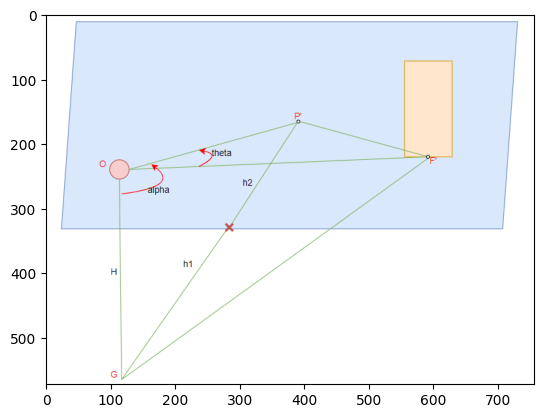

In [4]:
visualize_img2 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize2.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img2, cv2.COLOR_BGR2RGB))
plt.show()

```latex
Camera calibration

In [5]:
# Define the dimensions of checkerboard 
rows = 8
cols = 6

# Termination and criteria for the corner sub-pixel algorithm
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 
  
# Prepare object points
objectPoints = np.zeros((rows * cols, 3), np.float32)
objectPoints[:, :2] = np.mgrid[0:rows, 0:cols].T.reshape(-1, 2)

# Create the arrays to store the object points and the image points
objectPointsArray = []
imgPointsArray = []

# Save gray scale
gray = None

   
images = glob.glob('D:\python\Distance_measurement\CheckerBoards\*.jpg') 
  
for (index, path) in enumerate(images): 
    image = cv2.imread(path) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  
    ret, corners = cv2.findChessboardCorners(gray, (rows, cols), None) 
  
    # If desired number of corners can be detected then, 
    # refine the pixel coordinates and display 
    # them on the images of checker board 
    if ret: 
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        objectPointsArray.append(objectPoints) 
        imgPointsArray.append(corners)
        cv2.drawChessboardCorners(image, (rows, cols), corners, ret)
    else:
        print(f"Unable to detect corners in image: {path}")
    cv2.imshow('img', image) 
    cv2.waitKey(250) 
  
cv2.destroyAllWindows() 
  
h, w = image.shape[:2] 
  
  
# Perform camera calibration by 
# passing the value of above found out 3D points (threedpoints) 
# and its corresponding pixel coordinates of the 
# detected corners (twodpoints) 
def getParamters(objectPointsArray, imgPointsArray, gray):
    return cv2.calibrateCamera(objectPointsArray, imgPointsArray, gray.shape[::-1], None, None)

ret, matrix, distortion, r_vecs, t_vecs = getParamters(objectPointsArray, imgPointsArray, gray)
fx, fy, height, ppx, ppy, width = matrix[0][0], matrix[1][1], h, matrix[0][2], matrix[1][2], w
  

# Displaying required output 
print("Intrinsic matrix: \n{}\n".format(matrix)) 

matrix[0][2] = w / 2
matrix[1][2] = h / 2

new_intrinsic_matrix, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w, h), 1, (w, h))
print("new_intrinsic_matrix: \n{}\n".format(new_intrinsic_matrix))

Unable to detect corners in image: D:\python\Distance_measurement\CheckerBoards\frame_34.jpg
Unable to detect corners in image: D:\python\Distance_measurement\CheckerBoards\frame_36.jpg
Unable to detect corners in image: D:\python\Distance_measurement\CheckerBoards\frame_37.jpg
Intrinsic matrix: 
[[      923.9           0      494.53]
 [          0      926.38      383.15]
 [          0           0           1]]

new_intrinsic_matrix: 
[[      931.4           0      513.61]
 [          0      933.14      385.56]
 [          0           0           1]]



In [6]:
fx = 917.17
fy = 922.16

matrix = np.array([[fx, 0, w/2], [0, fy, h/2], [0, 0, 1]])
print(matrix)

[[     917.17           0         512]
 [          0      922.16         384]
 [          0           0           1]]


In [7]:
pixcel_w = s_w / w
pixcel_h = s_h / h

print("pixcel width: {} mm".format(pixcel_w))
print("pixcel height: {} mm".format(pixcel_h))

ox = matrix[0][2]
oy = matrix[1][2]

print("ox: {}".format(ox))
print("oy: {}".format(oy))

pixcel width: 0.003583984375 mm
pixcel height: 0.0035677083333333338 mm
ox: 512.0
oy: 384.0


```latex
Applying YOLOv8

real height 0 = 453 pixcel


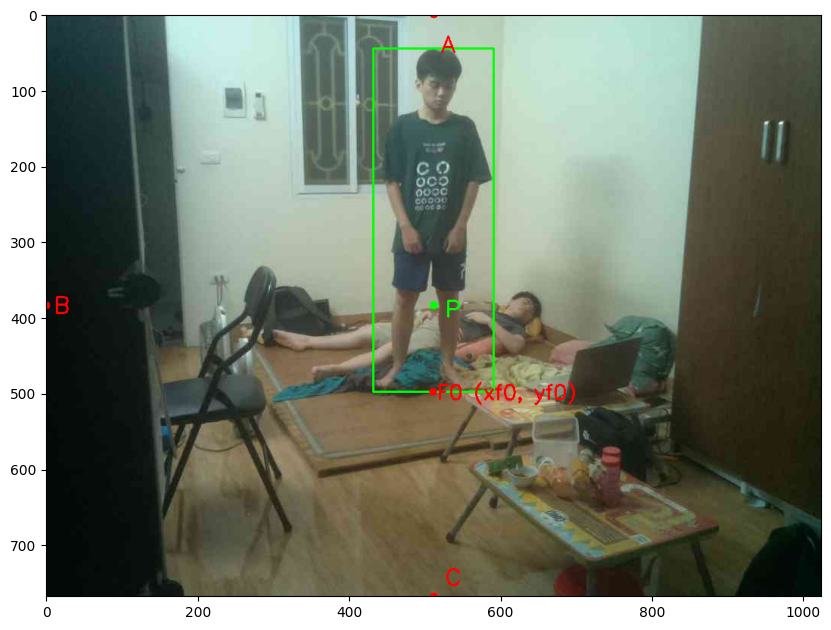

In [8]:
CONFIDENCE_THRESHOLD = 0.8
GREEN = (0, 255, 0)

detections = model(img, verbose=False)[0]
pos = []
F_pos = []
real_height = []
for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]

        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue

        # if the confidence is greater than the minimum confidence,
        # draw the bounding box on the frame
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        height = ymax - ymin
        real_height.append(height)
        pos.append((xmin, ymin, xmax, ymax))
        F_pos.append((int(0.5 * (xmin + xmax)), int(ymax), 0))
        cv2.rectangle(img, (xmin, ymin) , (xmax, ymax), GREEN, 2)
        n_people += 1
xf = int(0.5 * (xmin + xmax))
yf = int(ymax)

F = (xf, yf, 0)

img_shape = (int(img.shape[1]), int(img.shape[0]))
P = (int(img_shape[0] / 2), int(img_shape[1] / 2), 0)
B = (0, int(img_shape[1] / 2), 0)
A = (int(img_shape[0] / 2), 0, 0)
C = (int(img_shape[0] / 2), int(img_shape[1]), 0)
O = (int(img_shape[0] / 2), int(img_shape[1] / 2), f)

# cv2.circle(img, (xf, yf), radius=5, color=(0, 0, 255), thickness=-1)

cv2.circle(img, (B[0], B[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (A[0], A[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (P[0], P[1]), radius=5, color=(0, 255, 0), thickness=-1)
cv2.circle(img, (C[0], C[1]), radius=5, color=(0, 0, 255), thickness=-1)

# cv2.putText(img, "F (xf, yf)", (xf + 5, yf + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
for i in range (n_people):
    cv2.circle(img, (F_pos[i][0], F_pos[i][1]), radius=5, color=(0, 0, 255), thickness=-1)
    cv2.putText(img, f"F{i} (xf{i}, yf{i})", (F_pos[i][0] + 5, F_pos[i][1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    print("real height {} = {} pixcel".format(i, real_height[i]))

cv2.putText(img, "B", (B[0] + 10, B[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "A", (A[0] + 10, A[1] + 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "P", (P[0] + 15, P[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2.putText(img, "C", (C[0] + 15, C[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
for i in range(n_people):
    print(f"F{i} (xf{i}, yf{i}): {F_pos[i]}")

F0 (xf0, yf0): (511, 498, 0)


```latex
Calculate real world position

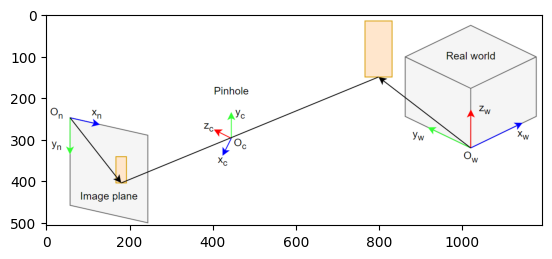

In [10]:
visualize_img3 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize3.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img3, cv2.COLOR_BGR2RGB))
plt.show()

```latex
From 2D image coordinate to 3D camera coordinate

$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
=
\begin{bmatrix}
zc.u \\
zc.v \\
zc
\end{bmatrix}
= 
\begin{bmatrix}
fx & 0 & ox & 0 \\
0 & fy & oy & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}

\begin{bmatrix}
xc \\
yc \\
zc \\
1
\end{bmatrix}
$$
```latex
Means
```
$$
\frac{xc}{zc}
=
\frac{u - ox}{fx}
$$

$$
\frac{yc}{zc}
=
\frac{v - oy}{fy}
$$

In [11]:
mtrx = np.array([[fx, 0, ox, 0], [0, fy, oy, 0], [0, 0, 1, 0]])
x_over_z = []
y_over_z = []

for i in range(n_people):
    x_over_z.append((F_pos[i][0] - ox) / fx)
    y_over_z.append((F_pos[i][1] - oy) / fy)

```latex
From camera coordiante to real world coordinate

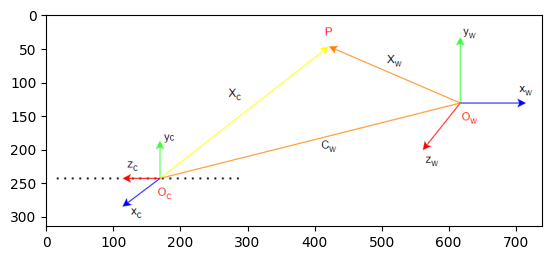

In [12]:
visualize_img4 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize4.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img4, cv2.COLOR_BGR2RGB))
plt.show()


```latex
R: Rotation matrix. 
t: Translation vector. 
```
$$
Xc = R.Xw + t   
$$

$$
\begin{bmatrix}
xc \\
yc \\
zc
\end{bmatrix}
=
\begin{bmatrix}
r11 & r12 & r13 \\
r21 & r22 & r23 \\
r31 & r32 & r33
\end{bmatrix}
.
\begin{bmatrix}
xw \\
yw \\
zw
\end{bmatrix}
+
\begin{bmatrix}
tx \\
ty \\
tz
\end{bmatrix}
$$

```latex

Set P is the origin of the world coordinate system. 
P: [0, 0, 0] 

Human's foot: [xw, yw, zw] 

Assume the person is on the ground, hence zw = 0. 
So, the Person's coordinates are: [xw, yw, 0] 

The Camera's coordinates are: cw = [0, h, -H]

In [13]:
rotation_matrix = np.array([[1, 0, 0],
                            [0, np.cos(math.radians(alpha)), np.sin(math.radians(alpha))],
                            [0, -np.sin(math.radians(alpha)), np.cos(math.radians(alpha))]])

print(rotation_matrix.T)
print(np.linalg.inv(rotation_matrix))

[[          1           0           0]
 [          0     0.25882    -0.96593]
 [          0     0.96593     0.25882]]
[[          1           0           0]
 [         -0     0.25882    -0.96593]
 [          0     0.96593     0.25882]]


In [14]:
# Camera in world coordinates
cw = np.array([[0], [d], [-H]])
t = np.dot(rotation_matrix, cw)
tx, ty, tz = t[0][0], t[1][0], t[2][0]
print("t: \n", t)

t: 
 [[          0]
 [   -0.09139]
 [    -4.3726]]


In [15]:
rotation_matrix_inv = np.linalg.inv(rotation_matrix)
print("Rotation_matrix_inv  \n {}\n".format(rotation_matrix_inv))

Xi = []
Xc = []
Xw = []
zc = []

r31 = rotation_matrix_inv[2][0]
r32 = rotation_matrix_inv[2][1]
r33 = rotation_matrix_inv[2][2]

for i in range(n_people):
    zc_i = (r31*tx + r32*ty + r33*tz) / (r31*x_over_z[i] + r32*y_over_z[i] + r33)
    Xi.append(np.array([[zc_i * F_pos[i][0]], [zc_i * F_pos[i][1]], [zc_i]]))
    Xc.append(np.array([[x_over_z[i] * zc_i], [y_over_z[i] * zc_i], [zc_i]]))
    zc.append(zc_i)
    Xw.append(-np.dot(rotation_matrix_inv, (Xc[i] - t)))

# for i in range (n_people):
#     print("Person: ", i)
#     print("Xi: \n{}\n".format(Xi[i] / zc[i]))
#     print("Xc: \n{}\n".format(Xc[i]))
#     print("Xw: \n{}\n".format(np.round(Xw[i], 6)))
i = 0
print("Person: ", i)
print("Xi: \n{}\n".format(Xi[i] / zc[i]))
print("Xc: \n{}\n".format(Xc[i]))
print("Xw: \n{}\n".format(np.round(Xw[i], 6)))

Rotation_matrix_inv  
 [[          1           0           0]
 [         -0     0.25882    -0.96593]
 [          0     0.96593     0.25882]]

Person:  0
Xi: 
[[        511]
 [        498]
 [          1]]

Xc: 
[[  0.0035169]
 [   -0.39875]
 [    -3.2256]]

Xw: 
[[  -0.003517]
 [     1.1876]
 [         -0]]



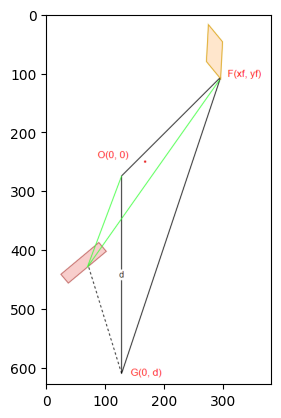

In [16]:
visualize_img5 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize5.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img5, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
GO = [0, d]
print(Xw[0].shape)
GF = [0 - Xw[i][0][0], d - Xw[i][1][0]]
cos_theta = (GO[0]*GF[0] + GO[1]*GF[1]) / (math.sqrt(GO[0]**2 + GO[1]**2) * math.sqrt(GF[0]**2 + GF[1]**2))
print("theta = ", np.degrees(np.arccos(cos_theta)))
print("GO: ", GO)
print("GF: ", GF)

(3, 1)
theta =  0.06688955681753823
GO:  [0, 4.2]
GF:  [0.0035168560497676957, 3.012442103675113]


In [18]:
theta = []
distance = []
for j in range(n_people):
    GO_tmp = [0, d]
    GF_tmp = [0 - Xw[j][0][0], d - Xw[j][1][0]]
    distance_tmp = math.sqrt(GF_tmp[0]**2 + GF_tmp[1]**2)
    cos_theta_tmp = (GO_tmp[0]*GF_tmp[0] + GO_tmp[1]*GF_tmp[1]) / (math.sqrt(GO_tmp[0]**2 + GO_tmp[1]**2) * math.sqrt(GF_tmp[0]**2 + GF_tmp[1]**2))
    theta_tmp = np.degrees(np.arccos(cos_theta_tmp))
    theta.append(theta_tmp)
    distance.append(distance_tmp)

for j in range(n_people):
    print("Person: ", j)
    print("theta = ", theta[j])
    print("distance = ", distance[j])
    print("\n")

Person:  0
theta =  0.06688955681753823
distance =  3.012444156539838




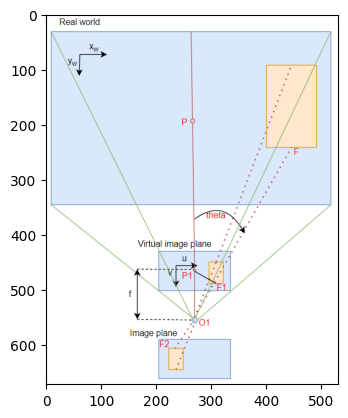

In [19]:
visualize_img1 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize1.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img1, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# Define a list of colors
colors = ["red", "blue", "pink", "purple", "orange", "darkred", "lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "white", "green", "lightblue", "lightgreen", "gray", "black", "lightgray"]

m = folium.Map(location=[UAV_lat, UAV_lon], zoom_start=50)
folium.Marker(location=[UAV_lat, UAV_lon], popup='UAV').add_to(m)

length = 0.0001
end_lat = UAV_lat + length * math.cos(math.radians(p))
end_lon = UAV_lon + length * math.sin(math.radians(p))

for j in range (n_people):
    length = 0.00001 * distance[j]
    if ox < F_pos[j][0]:
        end_lat_direct = UAV_lat + length * math.cos(math.radians(p + theta[j]))
        end_lon_direct = UAV_lon + length * math.sin(math.radians(p + theta[j]))
    else:
        end_lat_direct = UAV_lat + length * math.cos(math.radians(p - theta[j]))
        end_lon_direct = UAV_lon + length * math.sin(math.radians(p - theta[j]))
    # Draw the direct line
    folium.PolyLine([(UAV_lat, UAV_lon), (end_lat_direct, end_lon_direct)], color=colors[j % len(colors)]).add_to(m)
    folium.Marker(location=[end_lat_direct, end_lon_direct], popup=f'Person {j}', icon=folium.Icon(color=colors[j % len(colors)])).add_to(m)
    
# Draw the compass line
folium.PolyLine([(UAV_lat, UAV_lon), (end_lat, end_lon)], color="green").add_to(m)

m    